# L2正则 & dropout

## 这里会有两个版本，一个是手写版，另一个是Pytorch简单版本

In [1]:
from tool import *
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms

%load_ext autoreload
%autoreload
%matplotlib inline

这次构建一个稍微深一点的网络，然后尝试有没有两种正则对于他们的影响

函数清单：
  - 读取数据
  - 定义model
  - 定义参数
  - 定义loss
  - 定义dropout
  - 使用weight_decay充当L2
  - 开始训练
  - 可视化结果

In [7]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.FashionMNIST(root="./../data", download=False, train=True, transform=transformer)
mnist_test = torchvision.datasets.FashionMNIST(root="./../data", download=False, train=False, transform=transformer)


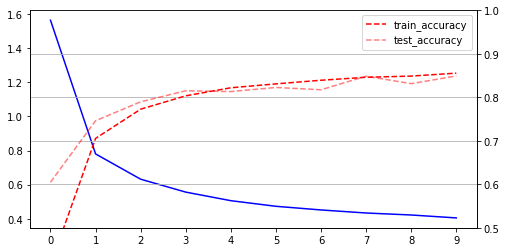

In [13]:
## 定义一个多层的感知器

W_1 = torch.normal(mean=0, std=0.01, size=(784, 800), requires_grad=True)
b_1 = torch.normal(mean=0, std=0.01, size=(800,), requires_grad=True)

W_2 = torch.normal(mean=0, std=0.01, size=(800, 256), requires_grad=True)
b_2 = torch.normal(mean=0, std=0.01, size=(256,), requires_grad=True)

W_3 = torch.normal(mean=0, std=0.01, size=(256, 10), requires_grad=True)
b_3 = torch.normal(mean=0, std=0.01, size=(10,), requires_grad=True)

params = [W_1, b_1, W_2, b_2, W_3, b_3]

## 实现relu， dropout
def relu(x):
    xx = torch.zeros_like(x)
    return torch.max(x, xx)

def dropout(x, p):
    
    if p == 0:
        return x
    elif p == 1:
        return torch.zeros_like(x)
    else:
        mask = (torch.rand(size=x.shape) > p).float()
        return mask * x / (1 - p)

def MLP(X, is_training=True):
    
    hidden_1 = relu(X.reshape(X.shape[0], -1) @ W_1 + b_1)
    if is_training:
        hidden_1 = dropout(hidden_1, p=0.5)
    hidden_2 = relu(hidden_1 @ W_2 + b_2)
    if is_training:
        hidden_2 = dropout(hidden_2, p=0.2)
    hidden_3 = hidden_2 @ W_3 + b_3
    
    return hidden_3

## 开始训练

epoch_num = 10
lr = 0.1

train_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr=lr, params=params, weight_decay=0.001)

animation = Animation(epoch_show_num=epoch_num, secondary=True)

for epoch in range(epoch_num):
    
    accu = Accumulator(3)

    for batch_X, batch_y in train_data_loader:
        batch_y_hat = MLP(batch_X)
        batch_loss = loss(batch_y_hat, batch_y)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            batch_num = len(batch_y)
            batch_accuracy = accuracy(batch_y_hat, batch_y)
            accu.add([batch_num, float(batch_loss) * batch_num, batch_accuracy])
        
        
    rst_1 = [x/accu.data[0] for x in accu.data][1:]
    rst_2 = accuracy_iter(lambda x: MLP(x, is_training=False), iter(test_data_loader))

    animation.add(
        data_l=[rst_1[0]], data_r=[rst_1[1], rst_2[0]],   
        legends_l=["train_loss"], legends_r=["train_accuracy", "test_accuracy"])

## torch用类写一下

[0.36648558303515116, 0.86855, 0.8485]


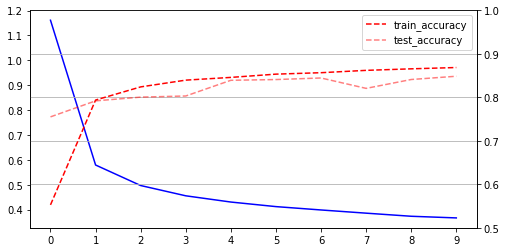

In [10]:
num_input, num_output = 784, 10
linear_input2 = 164
linear_input3 = 128

drop_out1 = 0.3
drop_out2 = 0.5

class MLP(torch.nn.Module):
    
    def __init__(self, num_input, num_output, linear_input2, linear_input3, is_training=True):
        
        super(MLP, self).__init__()
        self.linear_1 = torch.nn.Linear(num_input, linear_input2)
        self.linear_2 = torch.nn.Linear(linear_input2, linear_input3)
        self.linear_3 = torch.nn.Linear(linear_input3, num_output)
        self.relu = torch.nn.ReLU()
        self.is_training = is_training
        
    def forward(self, X):
        
        X = torch.flatten(X, start_dim=1)
        X = self.relu(self.linear_1(X))
        if self.is_training:
            X = torch.nn.Dropout(p=drop_out1)(X)
            
        X = self.relu(self.linear_2(X))
        if self.is_training:
            X = torch.nn.Dropout(p=drop_out2)(X)
        
        return self.linear_3(X)
    

mlp = MLP(num_input, num_output, linear_input2, linear_input3, is_training=True)
def init_weight(M):
    if type(M) == torch.nn.Linear:
        torch.nn.init.normal_(M.weight, mean=0, std=0.01)
mlp.apply(init_weight)
        
epoch_num, lr, batch_size = 10, 0.1, 64

train_data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr = lr, params=mlp.parameters(), weight_decay=0.00)
model = mlp


train_p1(epoch_num, model, loss, optimizer, train_data_loader, test_data_loader)

[0.3037874556859334, 0.8865166666666666, 0.8687]


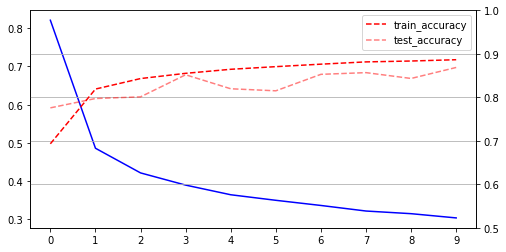

In [3]:
MLP = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
    )
    
## init参数

def init_weights(M):
    if type(M) == torch.nn.Linear:
        torch.nn.init.normal_(M.weight, mean=0, std=0.01)
        torch.nn.init.normal_(M.bias, mean=0, std=0.01)
        
MLP.apply(init_weights)

## loss、optimizer
model = MLP
epoch_num = 10
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(MLP.parameters(), lr=0.5)

train_p1(epoch_num, model, loss, optimizer, train_data_loader, test_data_loader)